In [119]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from math import *
import numpy as np
import os
from IPython.display import HTML
from tqdm import tqdm

In [85]:
interval = 0.001

In [91]:
# 3x3 memristor crossbar
# 전압으로 MEMRISTOR 저
class Memristor:
    def __init__(self, name):
        self.name = name
        self.x = 0.1
        self.xp = 0.1
        self.xn = 0.2
        self.vp = 1.5
        self.vn = 0.7
        self.alphap = 6
        self.alphan = 4
        self.a1 = 4e-4
        self.a2 = 3e-4
        self.ap = 0.032
        self.an = 0.001
        self.b = 1.0
        
        self.gf = 0.0
        
        self.interval = interval
        self.conductance = 0
        self.resistance = 0
    
    def change_x(self, V):
        if V >= 0:
            if self.x >= self.xp:
                self.f = exp(-self.alphap*(self.x - self.xp)) * (((self.xp - self.x)/(1 - self.xp)) + 1)
            else:
                self.f = 1.0
        elif V < 0:
            if self.x <= (1 - self.xn):
                self.f = exp(self.alphan*(self.x + self.xn - 1.0)) * (self.x/(1-self.xn))
            else:
                self.f = 1.0
            
        if V > self.vp:
            self.g = self.ap * (exp(V)-exp(self.vp))
        elif V < -self.vn:
            self.g = -self.an * (exp(-V)-exp(self.vn))
        else:
            self.g = 0
            
        self.gf = self.f * self.g
        self.x += self.gf * self.interval
    
    def activate(self, V):
        self.change_x(V)
        
        if V >= 0:
            curr = self.a1 * self.x * sinh(self.b * V)
        else:
            curr = self.a2 * self.x * sinh(self.b * V)
        
        self.resistance = V / curr
        self.conductance = 1 / self.resistance
        
        return curr

# weight mapping

In [10]:
w = np.array([[0.5,0.2,0.5],
             [0.5,0.2,0.5],
             [1.0,0.2,1.0],
             [0.5,0.5,1.0],
             [0.2,0.2,0.2],
             [1.0,1.0,0.2]])

In [11]:
w = w.reshape(9,2)

In [12]:
print(w)

[[0.5 0.2]
 [0.5 0.5]
 [0.2 0.5]
 [1.  0.2]
 [1.  0.5]
 [0.5 1. ]
 [0.2 0.2]
 [0.2 1. ]
 [1.  0.2]]


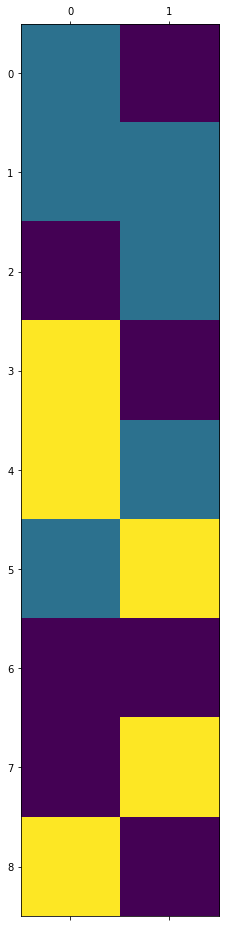

In [13]:
plt.matshow(w)

In [14]:
len(w)

9

In [15]:
# Building memristor crossbar architecture
for i in range(len(w)):
    for j in range(len(w[0])):
        exec('mem_%d%d = Memristor("mem_%d%d")'%(i,j,i,j))

In [16]:
# Mapping on the crossbar
def mapping(w):
    V = 1.7
    output = []
    for i, row in enumerate(w):
        out_row = []
        for j, t  in enumerate(row):
            for time in np.arange(0,t,interval):
                exec('mem_%d%d.activate(V)'%(i,j))
            
            exec('out_row.append(mem_%d%d.x)'%(i,j))
        output.append(out_row)
    
    return np.array(output)

In [17]:
a = mapping(w)

[[0.115043   0.10621186]
 [0.115043   0.115043  ]
 [0.10621186 0.115043  ]
 [0.12862764 0.10621186]
 [0.12862764 0.115043  ]
 [0.115043   0.12862764]
 [0.10621186 0.10621186]
 [0.10621186 0.12862764]
 [0.12862764 0.10621186]]


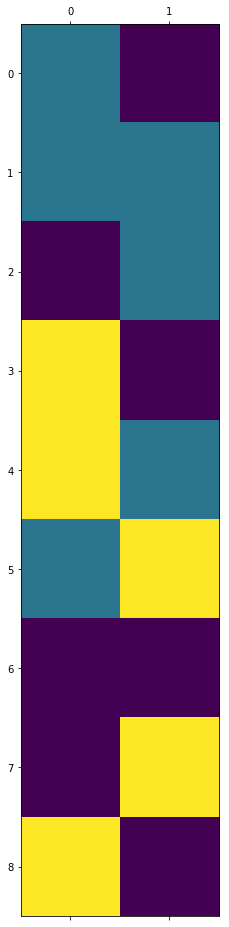

In [18]:
print(a)
plt.matshow(a)

In [19]:
X = np.array([[1,0,1],[0,1,0],[1,0,1]])
T = np.array([[1,1,1],[0,1,0],[0,1,0]])

In [20]:
print(X, '\n')
print(T)

[[1 0 1]
 [0 1 0]
 [1 0 1]] 

[[1 1 1]
 [0 1 0]
 [0 1 0]]


In [21]:
X = X.reshape(1,9)
T = T.reshape(1,9)

In [22]:
output1 = np.dot(X,w)
output2 = np.dot(T,w)

print(output1, output2)

[[2.9 1.6]] [[2.4 2.7]]


# After-imaging method

- 우선은 회로도에 대한 고려없이 해보았습니다

In [31]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("../dataset/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../dataset/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../dataset/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../dataset/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../dataset/t10k-labels-idx1-ubyte.gz


In [40]:
input_images[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [32]:
input_images = mnist.train.images[:1000]
print('input_images shape:',input_images.shape)
labels = mnist.train.labels[:1000]

input_images shape: (1000, 784)


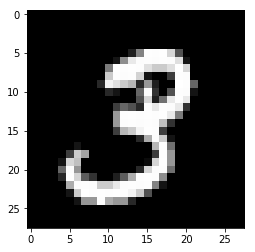

In [87]:
from PIL import Image

a = input_images[1]
im = np.reshape(a, [28,28])

plt.imshow(im, cmap='gray'); plt.show()

In [139]:
# Build Memristor crossbar
size = 11
row_num = size**2 # input image data size = 3*3
column_num = 10 # class number 
for i in range(row_num):
    for j in range(column_num):
        exec('mem_%d%d = Memristor("mem_%d%d")'%(i,j,i,j))

In [174]:
# 아래 내용을 하나의 class로 만들어도 괜찮을 것 같다.

class AfterImaging:
    def __init__(self):
        self.size = 11
        self.row_num = row_num
        self.column_num = 10
    
    def crossbar_matrix(self):
        self.mem_matrix = []
        for row in range(self.row_num):
            row_list = []
            for column in range(self.column_num):
                exec('row_list.append(mem_%d%d.conductance)'%(row,column))
            self.mem_matrix.append(row_list)
        return np.array(self.mem_matrix)
    
    def data_size_reduction(self, quantity=100):
        #os.mkdir("../dataset/size_reduced_image_path")
        #os.chdir("../dataset/size_reduced_image_path")
        
        input_images = mnist.train.images[:quantity]
        labels = mnist.train.labels[:quantity]
        size_reducted_images = []
        for im in input_images:
            pil_im = Image.fromarray(np.reshape(im, [28,28]))
            size_reducted_images.append(np.reshape(np.array(pil_im.resize([self.size, self.size])), [1, self.size**2])[0])
        return size_reducted_images, labels
    
    def split_train_test(self, images, labels, train_ratio=0.9):
        # img path 를 받아서 train, test set을 list로 추출해서 나눠줌 --> path는 좀 더 데이터 사이즈가 커졌을 때 사용해도 될 듯
        train_quantity = int(len(images)*train_ratio)
        train_image_list = images[:train_quantity]
        train_label_list = labels[:train_quantity]
        test_image_list = images[train_quantity:]
        test_label_list = labels[train_quantity:]
        return train_image_list, train_label_list, test_image_list, test_label_list
    
    def after_imaging(self, train_image, train_label, insert_time=0.05):
        # ms 단위의 이미지 sending (그 때 써놓았던 방식대로 작동될 수 있도록 하기)
        # image의 검은 부분은 -V 로 들어갈 수 있도록 만들기
        # generator 을 사용해서 하나씩 넣는 method 를 만들어도 괜찮을것같다. 
        voltage_inputs = np.array(train_image)+1
        for i, V in enumerate(voltage_inputs):
            for time in np.arange(0,insert_time,interval):
                exec('mem_%d%d.activate(V)'%(i,train_label))
        
    def mem_output(self, image_array):
        # 현재 멤리스터 상태에서 input 넣고 테스트하기
        crossbar_output = np.dot(image_array, self.crossbar_matrix)
        return crossbar_output
    
    def winner_take_all(self, crossbar_output):
        a = np.argmax(crossbar_output)
        output = np.zeros([10])
        output[a] = 1
        return output
    
    def loss_function(self, outputs, labels):
        total_loss = 0
        for i, label in enumerate(labels):
            label_onehot = np.zeros([1,10])
            label_onehot[label] = 1
            loss = np.square(label_onehot-outputs[i])
            total_loss += loss
        return total_loss
    
    def train_data_gen(self):
        for i in range(len(self.train_image_list)):
            yield self.train_image_list[i], self.train_label_list[i]
    
    def crossbar_animation(self, train_data):
    # input 은 없으며 그저 crossbar resistance를 plotting 해줌.
    # 그 plotting을 에니메이션적으로 할 수 있으면 좋겠다. 
    # 그 기준축을 평균으로 잡고, scale도 분산을 계산해서 plotting 되는 것 같은데 그렇게 되지 않도록 하기
        self.after_imaging(train_data[0], train_data[1], insert_time=0.03)
        self.ax1.clear()
        self.ax1.matshow(self.crossbar_matrix())
        
    def activate(self):
#         if size_reduction == True:
#             self.data_size_reduction(img_paths)
#             os.path.join("./size_reduced_image_path")
        # img_paths = os.path list
        fig = plt.figure(figsize=(10,20))
        self.ax1 = fig.add_subplot(1,1,1)
        
        size_reducted_images, labels = self.data_size_reduction()
        self.train_image_list, self.train_label_list, self.test_image_list, self.test_label_list = self.split_train_test(size_reducted_images, labels)
        
        self.anim = animation.FuncAnimation(fig, self.crossbar_animation, self.train_data_gen, interval=50)
        print('Done.')

Done.


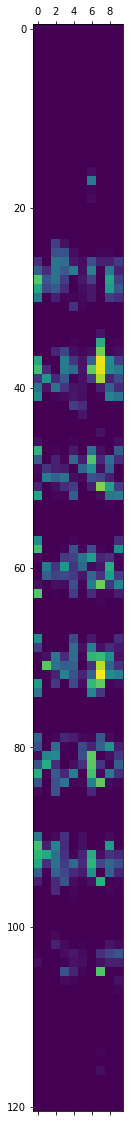

In [175]:
first_try = AfterImaging()
first_try.activate()

In [176]:
HTML(first_try.anim.to_html5_video())

### Testing with image input

다음 에니메이션: Post와 pre 사이에 신호가 오가는 에니메이션을 그려줘서, 멤리스터 하나에서 일어나는 일을 보여준다. 그래프를 서로 반대쪽으로 
x축 평행이동시켜서 전위차 개념을 도입한다. threshold voltage도 표시해준다. 

In [ ]:
def predict(crossbar_output):
    # winner take all method
    return prediction